<a href="https://colab.research.google.com/github/farhan1503001/Deep-Learning-Rhyme-Projects/blob/main/Variational_Autoencoder(VAE)_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Compression and Generation using Variational Autoencoders in Python

### Project Outline

**Task 1**: Introduction (this section)

**Task 2**: Exploratory Data Analysis and Preprocessing

**Task 3**: Training/Validation Split

**Task 4**: Creating Data Loaders

**Task 5**: VAE Architecture and Model Creation

**Task 6**: Training Loop

**Task 7**: Results and Other Uses

## Task 1: Introduction

I will explain the VAE briefly, but for additional information, feel free to check out the following resources:

- [Resource 1: Blog Post](https://www.jeremyjordan.me/variational-autoencoders/)
- [Resource 2: Theory Post](https://ermongroup.github.io/cs228-notes/inference/variational/)
- [Resource 3: Lecture Video](https://www.youtube.com/watch?v=P78QYjWh5sM&feature=youtu.be)

In addition, our VAE model in PyTorch has been adapted from the official PyTorch implementation you can find in [this repo](https://github.com/pytorch/examples/tree/master/vae). Enjoy the project!

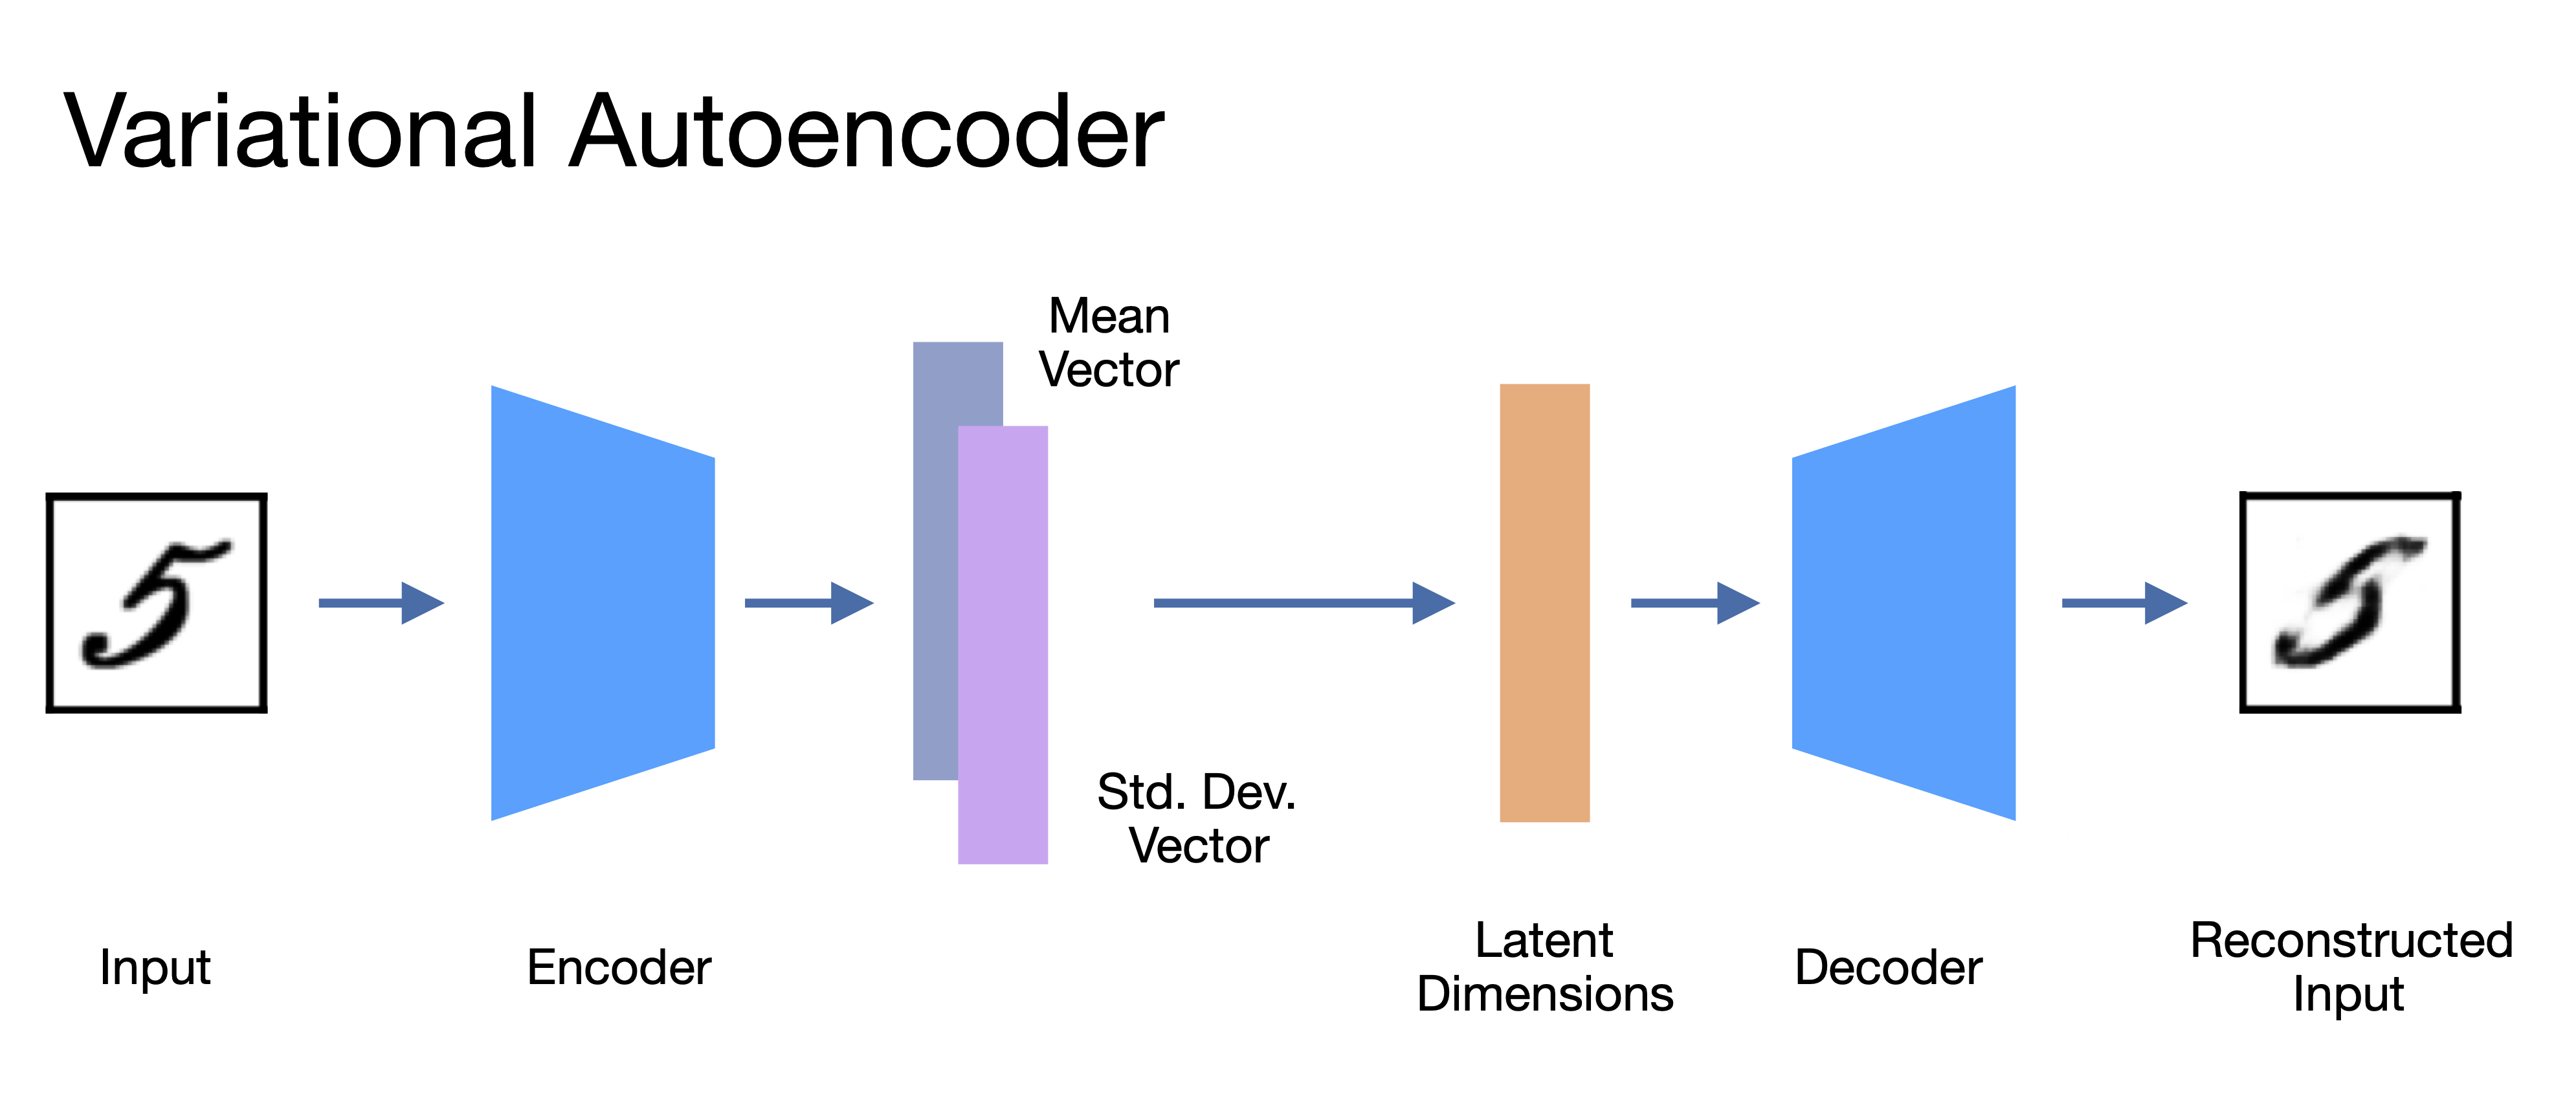

In [ ]:
#Importing necessary libraries
import torch
from torch.utils.data import DataLoader,Dataset
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm.notebook import tqdm
import random
import os
import shutil #This library is used for copying
random.seed(5)

#Now libraries for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np


In [ ]:
#Now setting up all the necessary hyperparameters
epochs=1000
batch_size=64
torch.manual_seed(42)

Device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {Device}')

Device: cuda


In [ ]:
!unzip -q '/content/Font.zip'

## Task 2: Exploratory Data Analysis and Preprocessing

We use the computer-generated fonts of the [Character Font Images Data Set](http://archive.ics.uci.edu/ml/datasets/Character+Font+Images#).

In [ ]:
#Here show_img displays the image
def show_image(image):
  #First transform the image from tensor to pil
  image=image.permute(1,2,0)
  #if the image grayscale then for viewing we don't need to have channel
  if image.shape[2]==1:
    image=image.view(image.shape[0],image.shape[1])
  plt.title(f"Image has size {image.cpu().numpy().shape}")
  plt.imshow(image,cmap='gray')
  plt.show()

In [ ]:
#Now writing tranforminng function for general augmentation:
transforms_gen=transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),#it will convert the image to grayscale format
        transforms.Resize(50), #will convert image to size 50,50,1 as previously channels is defined as 1
        transforms.ToTensor()   #it will convert the image to tensor format
    ]
)

#Now as our transformer function has been written we will try to write a dummy data loader for data inspection

view_batch=DataLoader(
    dataset=datasets.ImageFolder('Font/Font/all/',transform=transforms.ToTensor()),
                                 batch_size=1,shuffle=True
                                 )  #just tensor making


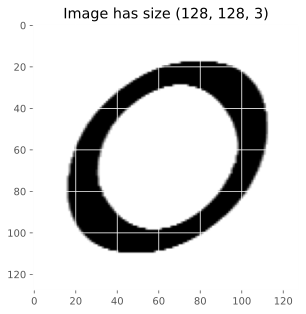

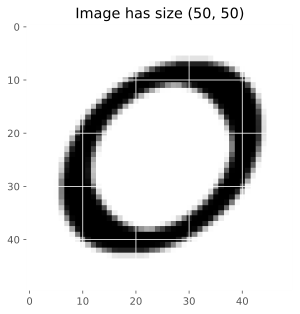

In [ ]:
#Now we will view a single image from the batch we have just created
for batch in view_batch:
  org_image=batch[0][0]
  show_image(org_image)
  show_image(transforms_gen(transforms.ToPILImage()(org_image)))
  break

# Training and Validation Split

In [ ]:
#Now in this phase we will iterate over the folders and read their images
folders=os.listdir("Font/Font/all") #Now we we have all the folders name here
#Now we will ignore the names of the hidden folders whose name usually start with . at the very first character
folders=[folder for folder in folders if folder[0]!='.']
#Now we will create train and validation set
os.mkdir('Font/Font/train')
os.mkdir('Font/Font/val')
#Now we will create folder with same name inside train and val just as they were in all
for folder in tqdm(folders):
  os.mkdir(f'Font/Font/val/{folder}')
  os.mkdir(f'Font/Font/train/{folder}')
  #Now folders have been created now push images
  images=os.listdir(f"Font/Font/all/{folder}")

  images=[image for image in images if image[0]!='.']
  random.shuffle(images)

  for image in images[:20]:
    shutil.copy(f"Font/Font/all/{folder}/{image}",f"Font/Font/val/{folder}/{image}")

  for image in images[20:]:
    shutil.copy(f"Font/Font/all/{folder}/{image}",f"Font/Font/train/{folder}/{image}")



  0%|          | 0/4 [00:00<?, ?it/s]

## Task 4: Creating Data Loaders

# Creating DataLoaders

In [ ]:
transforms_set=transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(size=50),
        transforms.ToTensor()
    ]
)

trainloader=DataLoader(
    dataset=datasets.ImageFolder('Font/Font/train',transform=transforms_set),
    batch_size=batch_size,
    shuffle=True
)
validloader=DataLoader(
    dataset=datasets.ImageFolder('Font/Font/val',transform=transforms_set),
    batch_size=batch_size,
    shuffle=True
)

# Creation of Variational Autoencoders

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()

    z=32
    self.fc1=nn.Linear(50*50,1000)
    self.fc_2a=nn.Linear(1000,z) #We will use it as mu
    self.fc_2b=nn.Linear(1000,z) #We will use it as svd
    self.fc3=nn.Linear(z,1000)
    self.fc4=nn.Linear(1000,50*50)

  def encoder(self,x):
    h1=F.relu(self.fc1(x))
    return self.fc_2a(h1),self.fc_2b(h1)
  def parameterize_latentspace(self,mu,logvar):
    std=torch.exp(0.5*logvar)
    eps=torch.randn_like(std)
    return mu+eps*std

  def decode(self,z):
    h3=F.relu(self.fc3(z))
    h4=torch.sigmoid(self.fc4(h3))
    return h4

  def forward(self,x):
    mu,logvar=self.encoder(x.view(-1,50*50)) #Mainly flattens the input and then feed it as it's simple neural network
    latent_gaus=self.parameterize_latentspace(mu,logvar)
    return self.decode(latent_gaus),mu,logvar

In [ ]:
#Now loss function consisting of BCE loss and KLD or kullback divergence loss
def loss_function(new_output,input,mu,logvar):
  BCE=F.binary_cross_entropy(new_output,input.view(-1,50*50),reduction='sum')
  KLD=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
  return BCE+KLD

In [ ]:
#Now model uploading
model=VAE().to(Device)
optimizer=optim.Adam(model.parameters(),lr=1e-3)

# Training Loop
Starting with evaluation function ending with main training function

In [ ]:
#At first evaluator function
def evaluator(validation_data=validloader):
  #At first set the data in evaluator mode
  model.eval()
  val_loss=0.0
  #No gradient is required so no grad mode is set
  with torch.no_grad():
    for i,(data,_) in enumerate(validation_data):
      #At first send whole data to cuda
      data=data.to(Device)
      #data is fed to model
      recon_image,mu,logvar=model(data)
      #Now find out the validation loss
      loss=loss_function(recon_image,data,mu,logvar)

      #Add the loss to validation loss
      val_loss+=loss.item()
      #Now for saving some generated images
      if i==0:
        n=min(data.size(0),16)
        comparison=torch.cat([data[:n],recon_image.view(batch_size,1,50,50)[:n]])
        save_image(comparison.cpu(),"Font/Font/Results/reconstruction_"+str(epoch)+".png",nrows=n)
      val_loss /= len(validation_data.dataset)
      return val_loss
def sample_latent_space(epoch):
  with torch.no_grad():
    sample=torch.randn(64,32).to(Device)
    sample=model.decode(sample).cpu()

    save_image(sample.view(64,1,50,50),
               "Font/Font/Results/sample "+str(epoch)+" .pdf"
               )

In [ ]:
#Now we are ready for viewing our train function
def train(epoch):
  #At first set the model in training format
  model.train()
  train_loss=0.0
  #Now for visual representation of loop use tqdm
  progress_bar=tqdm(trainloader,desc='Epoch {:03d}'.format(epoch),leave=False,disable=False)
  for data,_ in progress_bar:
    #Send the dataset to device
    data=data.to(Device)
    #Now as we will train we will set up optimizer
    optimizer.zero_grad()
    recon_batch,mu,logvar=model(data)
    #Now calculate loss using loss function
    loss=loss_function(recon_batch,data,mu,logvar)
    #Now perform backprop
    loss.backward()
    #Now add the loss value
    train_loss+=loss.item()
    #Now perform optimizer step
    optimizer.step()

    progress_bar.set_postfix({"Training Loss":'{:.3f}'.format(loss.item()/len(data))})

  average_train_loss=train_loss/len(trainloader.dataset)
  tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
  val_loss=evaluator(validloader)
  tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))
  train_losses.append(average_train_loss)
  val_losses.append(val_loss)
  if epoch%50==0:
    torch.save(model.state_dict(),f"Font/Font/Models/epoch_{epoch}.model")

In [ ]:
epochs=100

In [ ]:

train_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    train(epoch)
    sample_latent_space(epoch)

np.savetxt('Font/Font/Models/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt('Font/Font/Models/validation_losses.txt', np.array(val_losses), delimiter='\n')

Epoch 001:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 288.476
				====> Validation set loss: 264.163


Epoch 002:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 280.570
				====> Validation set loss: 253.445


Epoch 003:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 276.762
				====> Validation set loss: 255.980


Epoch 004:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 271.462
				====> Validation set loss: 244.049


Epoch 005:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 270.191
				====> Validation set loss: 250.493


Epoch 006:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 264.319
				====> Validation set loss: 230.613


Epoch 007:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 260.782
				====> Validation set loss: 238.307


Epoch 008:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 257.719
				====> Validation set loss: 228.376


Epoch 009:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 254.001
				====> Validation set loss: 227.856


Epoch 010:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 253.117
				====> Validation set loss: 238.850


Epoch 011:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 250.621
				====> Validation set loss: 229.601


Epoch 012:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 247.515
				====> Validation set loss: 214.940


Epoch 013:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 245.931
				====> Validation set loss: 225.494


Epoch 014:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 244.441
				====> Validation set loss: 217.373


Epoch 015:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 242.769
				====> Validation set loss: 223.277


Epoch 016:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 240.572
				====> Validation set loss: 229.710


Epoch 017:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 238.618
				====> Validation set loss: 224.167


Epoch 018:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 237.031
				====> Validation set loss: 219.105


Epoch 019:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 236.005
				====> Validation set loss: 218.834


Epoch 020:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 233.912
				====> Validation set loss: 221.031


Epoch 021:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 233.671
				====> Validation set loss: 218.357


Epoch 022:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 022): 232.232
				====> Validation set loss: 200.306


Epoch 023:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 023): 231.183
				====> Validation set loss: 213.124


Epoch 024:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 024): 229.022
				====> Validation set loss: 207.194


Epoch 025:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 025): 228.156
				====> Validation set loss: 223.167


Epoch 026:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 026): 227.317
				====> Validation set loss: 209.397


Epoch 027:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 027): 226.105
				====> Validation set loss: 200.427


Epoch 028:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 028): 223.922
				====> Validation set loss: 207.937


Epoch 029:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 029): 222.905
				====> Validation set loss: 209.249


Epoch 030:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 030): 221.917
				====> Validation set loss: 201.426


Epoch 031:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 031): 220.455
				====> Validation set loss: 208.358


Epoch 032:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 032): 219.753
				====> Validation set loss: 206.418


Epoch 033:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 033): 219.074
				====> Validation set loss: 205.688


Epoch 034:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 034): 218.113
				====> Validation set loss: 210.205


Epoch 035:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 035): 218.390
				====> Validation set loss: 206.539


Epoch 036:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 036): 215.983
				====> Validation set loss: 200.969


Epoch 037:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 037): 217.720
				====> Validation set loss: 198.876


Epoch 038:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 038): 215.845
				====> Validation set loss: 200.434


Epoch 039:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 039): 214.621
				====> Validation set loss: 202.942


Epoch 040:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 040): 213.646
				====> Validation set loss: 204.105


Epoch 041:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 041): 214.434
				====> Validation set loss: 197.288


Epoch 042:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 042): 212.722
				====> Validation set loss: 204.963


Epoch 043:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 043): 211.536
				====> Validation set loss: 199.248


Epoch 044:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 044): 211.302
				====> Validation set loss: 201.629


Epoch 045:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 045): 211.681
				====> Validation set loss: 191.288


Epoch 046:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 046): 210.357
				====> Validation set loss: 207.051


Epoch 047:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 047): 209.756
				====> Validation set loss: 193.400


Epoch 048:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 048): 210.158
				====> Validation set loss: 204.401


Epoch 049:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 049): 208.383
				====> Validation set loss: 194.372


Epoch 050:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 050): 208.790
				====> Validation set loss: 186.491


Epoch 051:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 051): 208.356
				====> Validation set loss: 195.936


Epoch 052:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 052): 206.184
				====> Validation set loss: 194.561


Epoch 053:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 053): 206.399
				====> Validation set loss: 195.543


Epoch 054:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 054): 206.752
				====> Validation set loss: 206.540


Epoch 055:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 055): 206.394
				====> Validation set loss: 200.384


Epoch 056:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 056): 206.276
				====> Validation set loss: 195.067


Epoch 057:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 057): 205.565
				====> Validation set loss: 194.774


Epoch 058:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 058): 204.998
				====> Validation set loss: 197.593


Epoch 059:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 059): 205.264
				====> Validation set loss: 197.378


Epoch 060:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 060): 203.714
				====> Validation set loss: 195.942


Epoch 061:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 061): 203.720
				====> Validation set loss: 191.031


Epoch 062:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 062): 204.278
				====> Validation set loss: 189.062


Epoch 063:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 063): 204.108
				====> Validation set loss: 197.402


Epoch 064:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 064): 202.440
				====> Validation set loss: 195.253


Epoch 065:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 065): 202.880
				====> Validation set loss: 191.340


Epoch 066:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 066): 201.475
				====> Validation set loss: 180.380


Epoch 067:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 067): 201.935
				====> Validation set loss: 188.647


Epoch 068:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 068): 202.811
				====> Validation set loss: 190.297


Epoch 069:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 069): 200.964
				====> Validation set loss: 189.269


Epoch 070:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 070): 200.505
				====> Validation set loss: 193.879


Epoch 071:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 071): 200.038
				====> Validation set loss: 183.842


Epoch 072:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 072): 199.503
				====> Validation set loss: 186.520


Epoch 073:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 073): 199.554
				====> Validation set loss: 192.387


Epoch 074:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 074): 199.798
				====> Validation set loss: 192.906


Epoch 075:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 075): 199.026
				====> Validation set loss: 188.048


Epoch 076:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 076): 199.909
				====> Validation set loss: 186.664


Epoch 077:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 077): 199.090
				====> Validation set loss: 182.708


Epoch 078:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 078): 198.396
				====> Validation set loss: 180.515


Epoch 079:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 079): 198.162
				====> Validation set loss: 192.541


Epoch 080:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 080): 198.402
				====> Validation set loss: 182.495


Epoch 081:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 081): 198.358
				====> Validation set loss: 195.599


Epoch 082:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 082): 197.270
				====> Validation set loss: 194.402


Epoch 083:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 083): 198.222
				====> Validation set loss: 191.908


Epoch 084:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 084): 197.163
				====> Validation set loss: 183.566


Epoch 085:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 085): 196.252
				====> Validation set loss: 190.539


Epoch 086:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 086): 197.940
				====> Validation set loss: 195.076


Epoch 087:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 087): 196.468
				====> Validation set loss: 186.990


Epoch 088:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 088): 196.304
				====> Validation set loss: 192.928


Epoch 089:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 089): 195.096
				====> Validation set loss: 187.176


Epoch 090:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 090): 196.175
				====> Validation set loss: 181.041


Epoch 091:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 091): 196.450
				====> Validation set loss: 182.850


Epoch 092:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 092): 196.675
				====> Validation set loss: 187.769


Epoch 093:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 093): 195.580
				====> Validation set loss: 185.617


Epoch 094:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 094): 194.056
				====> Validation set loss: 194.531


Epoch 095:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 095): 194.699
				====> Validation set loss: 186.180


Epoch 096:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 096): 194.352
				====> Validation set loss: 183.376


Epoch 097:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 097): 195.263
				====> Validation set loss: 181.283


Epoch 098:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 098): 195.149
				====> Validation set loss: 182.622


Epoch 099:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 099): 194.392
				====> Validation set loss: 179.203


Epoch 100:   0%|          | 0/48 [00:00<?, ?it/s]

Training set loss (average, epoch 100): 194.819
				====> Validation set loss: 186.184


In [ ]:
model.load_state_dict(torch.load("Font/Font/Models/epoch_50.model",map_location=torch.device('cpu')))

<All keys matched successfully>

# Results and Visualization

In [ ]:
train_losses=np.loadtxt("Font/Font/Models/training_losses.txt")
valid_losses=np.loadtxt("Font/Font/Models/validation_losses.txt")

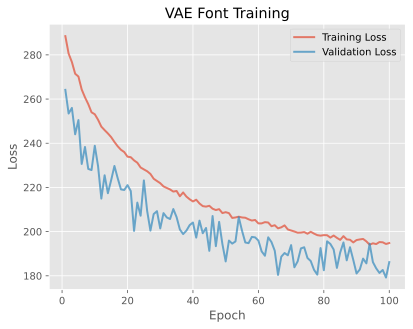

In [ ]:
plt.plot(
    range(1,len(train_losses)+1),
    train_losses,
    label="Training Loss",
    linewidth=2,
    alpha=0.7
)
plt.plot(
   range(1,len(val_losses)+1),
   val_losses,
   label="Validation Loss",
   linewidth=2,
   alpha=0.7
)
plt.title("VAE Font Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
pass

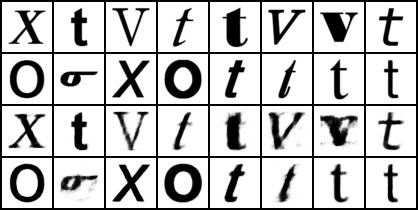

# After 57 epochs

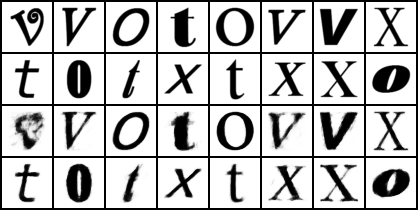

# After 80 epochs
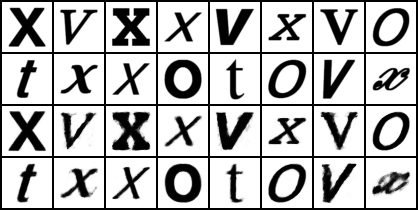

# After 100 epochs
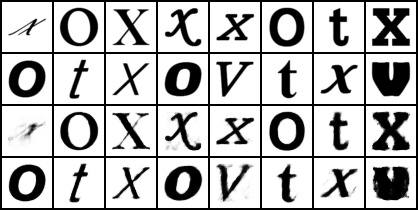

### CelebA Reconstructions with 500-D Latent Space

[CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
